(6282, 24, 12)
(6282, 3)


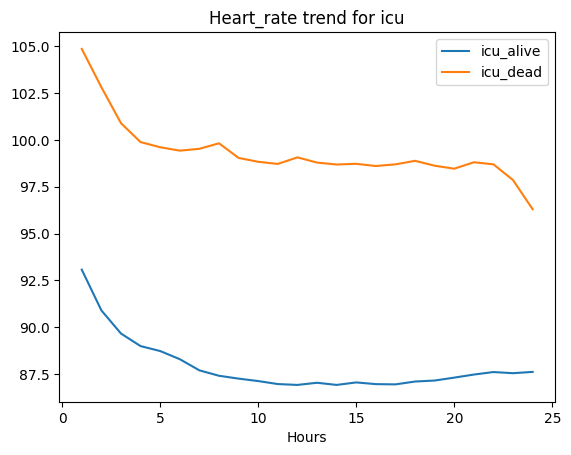

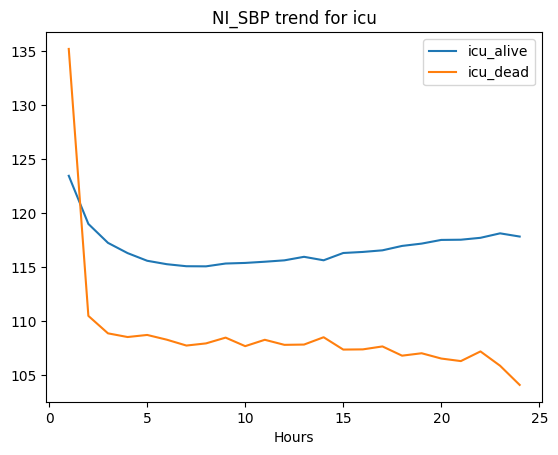

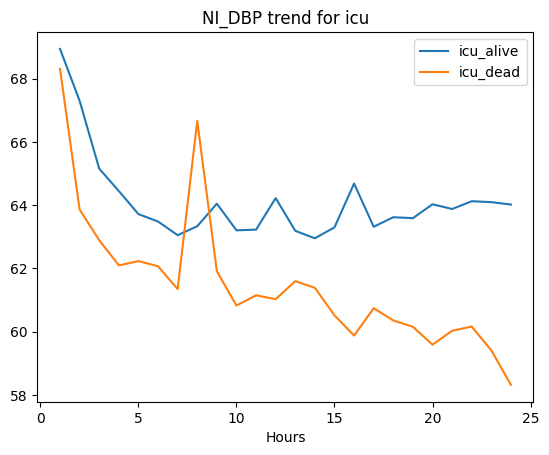

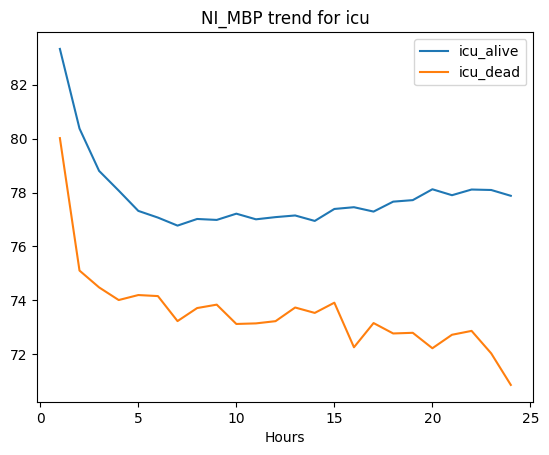

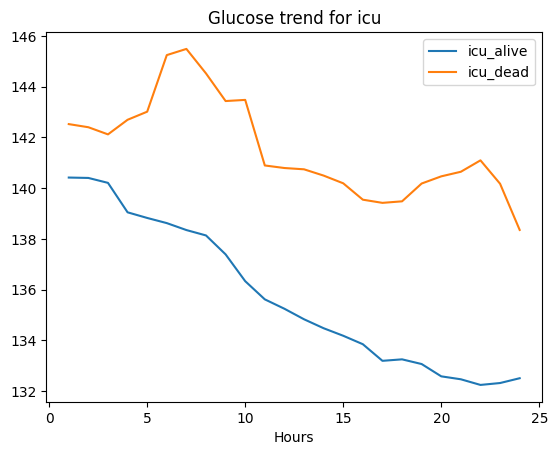

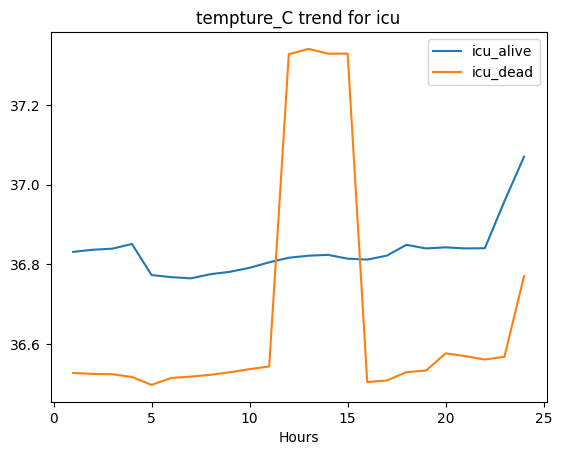

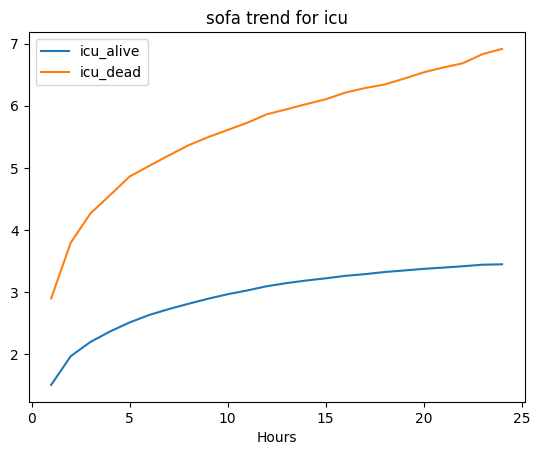

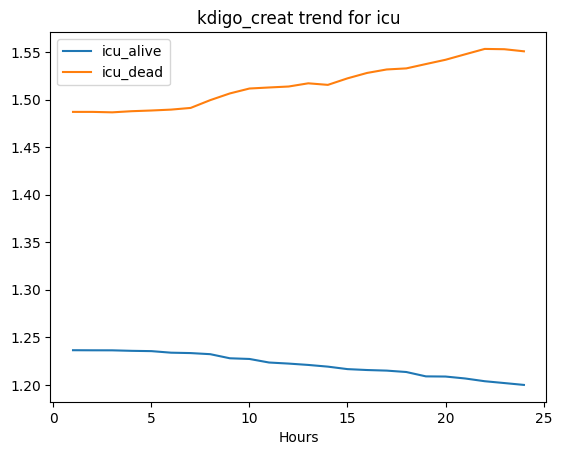

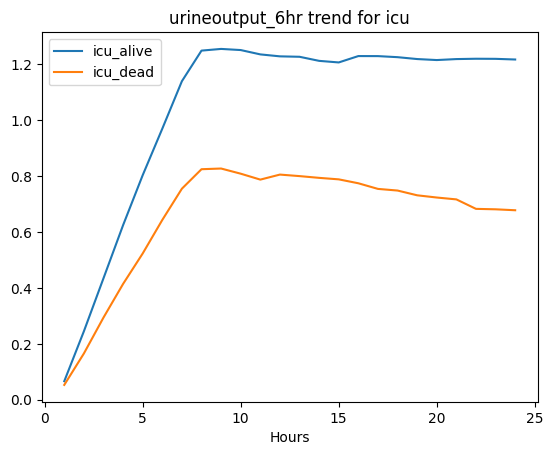

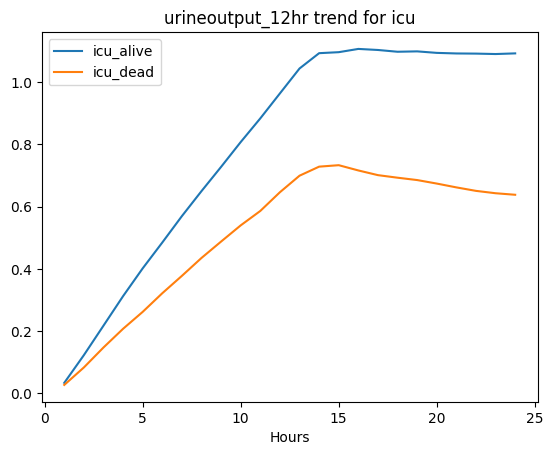

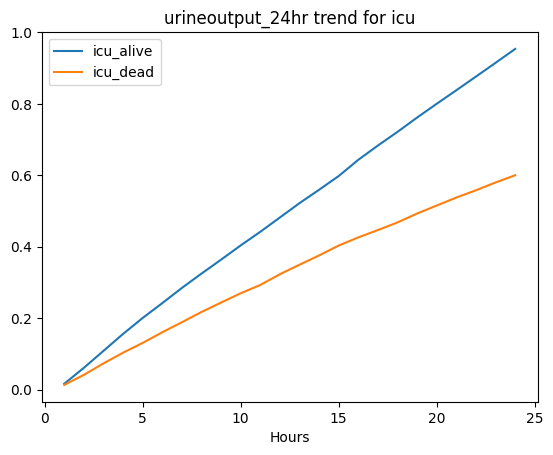

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from cprint import cprint
from collections import defaultdict

# Read the ground truth data
data_X = np.load('./data_npy/data_X_final.npy')
data_y = np.load('./data_npy/data_y_final.npy')
data_y = data_y[:, 0:3]
cprint('{}'.format(data_X.shape))
cprint('{}'.format(data_y.shape))



# Convert data from .npy to dataframe format
data_X_shape = data_X.shape
data_y_shape = data_y.shape
data_X_reshaped = data_X.reshape(-1, data_X_shape[2])
data_y_reshaped = np.repeat(data_y, data_X_shape[1], axis=0) # repeat label of patients for each timesteps

data_X_columns = ['icu_timestep', 'Heart_rate', 'NI_SBP', 'NI_DBP', 'NI_MBP', 'Glucose', 'tempture_C', 'sofa', 'kdigo_creat', 'urineoutput_6hr', 'urineoutput_12hr', 'urineoutput_24hr']
data_y_columns = []

df = pd.DataFrame(data_X_reshaped, columns=data_X_columns)
df['stay_id'] = data_y_reshaped[:, 0]
df['label_hosp'] = data_y_reshaped[:, 1]
df['label_icu'] = data_y_reshaped[:, 2]

# re-assign the timestep for each patient according to the order of the original values
df.sort_values(['stay_id', 'icu_timestep'], inplace=True)
df['icu_timestep'] = df.groupby('stay_id')['icu_timestep'].transform(lambda x: x.rank(method='first').astype(int))



mortality_type = 'icu' # type of mortality to plot the trend

data_X_columns.remove('icu_timestep')
trend_columns = data_X_columns
summary_alive = defaultdict(list)
summary_dead = defaultdict(list)
# seperate the for alive set and dead set
df_alive = df[df['label_{}'.format(mortality_type)] == 0]
df_dead = df[df['label_{}'.format(mortality_type)] == 1]



for t in range(1, 25):
    # dataframe for the specific timestep
    df_t_alive = df_alive[df_alive['icu_timestep'] == t]
    df_t_dead = df_dead[df_dead['icu_timestep'] == t]
    # for each features, store the mean value at that timestep for alive set and dead set
    for column in trend_columns:
        mean_alive = df_t_alive[column].mean()
        summary_alive[column].append(mean_alive)

        mean_dead = df_t_dead[column].mean()
        summary_dead[column].append(mean_dead)

# save the trend plot for alive set and dead set
def plot_trend(data_alive, data_dead, type):
    output_dir = './trend/{}'.format(type)
    os.makedirs(output_dir, exist_ok=True)
    for column in trend_columns:
        plt.figure()
        hours = [i + 1 for i in range(len(data_alive[column]))]
        plt.plot(hours, data_alive[column], label='{}_alive'.format(type))
        plt.plot(hours, data_dead[column], label='{}_dead'.format(type))
        plt.xlabel('Hours')
        plt.title('{} trend for {}'.format(column, type))
        plt.legend()
        plt.savefig(os.path.join(output_dir, '{}.png'.format(column)))


plot_trend(summary_alive, summary_dead, mortality_type)
    

